In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace

In [2]:
%matplotlib inline
import pickle
import json
import glob
import re
import os
import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns

import utils
from train_lstm import RotReacherLSTM
from reacher_def import RotReacherEnv

In [3]:
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 10,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': False,
          'figure.figsize': [5, 5]}
plt.rcParams.update(params)

In [13]:
def test_model_no_planning(model_dir, open_loop=False, traj_num=1000, n_steps=28, max_action=0.1, model_epoch_num=None, unit='m'):
    ### load the last LSTM model (or as specified in epoch_num) in the given directory
    assert unit in ['m', 'cm']
    
    if model_epoch_num is None:
        model, settings,_ = utils.load_latest_model(model_dir=model_dir)
    else:
        model_dir = os.path.join(model_dir, 'model_{:d}.ckpt'.format(model_epoch_num))
        model, settings = utils.load_model(model_path=model_dir)
        
    mode = settings['mode']
    
    unit_scaling = 100. if unit == 'm' else 1.
    
    reset_bits = np.zeros([traj_num, n_steps, 1])
    actions = np.random.uniform(-max_action, max_action, size=[traj_num, n_steps, 2])

    plt.figure()
    plt.hist(actions.flatten(),100)
    obs_truth = np.zeros([traj_num, n_steps+1, 2])
    vels_truth = np.zeros([traj_num, n_steps+1, 2])
    obs_pred = np.zeros([traj_num, n_steps+1, 2])
    vels_pred = np.zeros([traj_num, n_steps+1, 2])
    obs_act = np.zeros([traj_num, n_steps+1, 2])
    goals = np.zeros([traj_num, 2])
    
    env_path = os.path.join(Path().resolve(), 'rot_reacher_humanlike.xml')
    env = RotReacherEnv(mode=mode, model_path=env_path, max_action=max_action, test_mode=True)
    
    ### loop through trajectories and record true observations and, if closed-loop, predictions
    for t in range(traj_num):
        obs = env.reset_model()
        obs_truth[t,0] = obs[:2]
        obs_pred[t,0] = obs[:2]
        vels_truth[t,0] = env.sim.get_state().qvel[:2]
        vels_pred[t,0] = vels_truth[t,0]
        obs_act[t,0] = obs[2:]
        goals[t] = env.goal
        
        for n in range(n_steps):
            if reset_bits[t,n]:
                obs = env.reset_model()
            else:
                obs, _, _, _ = env.step(actions[t,n])  # do a simulation step 
            obs_truth[t,n+1] = obs[:2]
            obs_act[t,n+1] = obs[2:]
            vels_truth[t,n+1] = env.sim.get_state().qvel[:2]
        
    if open_loop:
        obs_pred, vels_pred = model.predict_trajectory(obs_truth[:,[0]], vels_truth[:,[0]], actions, reset_bits)
    else:
        for n in range(n_steps):
            obs, vels = model.predict_next_state(obs_truth[:,:n+1], vels_truth[:,:n+1], actions[:,:n+1], reset_bits[:,:n+1])
            obs_pred[:,n+1] = obs[:,-1]
            vels_pred[:,n+1] = vels[:,-1]
            
    ### compute errors per step
    errors = np.linalg.norm(obs_pred[:,1:]-obs_truth[:,1:], axis=2)
    error_means = np.mean(errors, axis=0)
    error_sem = np.std(errors, axis=0) / np.sqrt(traj_num)
    plt.figure()
    plt.errorbar(range(len(error_means)), error_means*unit_scaling, yerr=error_sem*unit_scaling)
    plt.xlabel("Steps")
    plt.ylabel("Error (cm)")
    
    ### plot a few trajectories to compare predictions with ground truth observations
    figs = []
    for t in range(10):        
        fig, ax = plt.subplots(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
        figs.append(fig)
        plt.ion()
        start = plt.Circle([0,0],1.6, color=[0.3,0.3,0.3], alpha=0.5)
        goal = plt.Circle(goals[t]*unit_scaling, 1.6, edgecolor='k', fill=False, linewidth=4, alpha=0.5)
        
        ax.scatter(obs_pred[t,:,0]*unit_scaling, obs_pred[t,:,1]*unit_scaling, color=[1,0,0], s=50, label='predicted')
        ax.scatter(obs_truth[t,:,0]*unit_scaling, obs_truth[t,:,1]*unit_scaling, color=[0,0,0], s=50, label='observed')
        ax.scatter(obs_act[t,:,0]*unit_scaling, obs_act[t,:,1]*unit_scaling, color=[0.7,0.7,0.7], s=50, label='actual')

        ax.add_artist(start)
        ax.add_artist(goal)
        ax.set_xlim([-10, 10])
        ax.set_ylim([-10, 10])
        ax.set_aspect('equal')
        ax.set_xlabel('x (cm)')
        ax.set_ylabel('y (cm)')
        legend = ax.legend()
        frame = legend.get_frame()
        frame.set_facecolor('0.9')
        frame.set_edgecolor('0.9')
        ax.set_frame_on(False)
        #plt.title('Example trajectory')
        plt.tight_layout()
        ax.grid()
        
    print('Average error: {} cm'.format(np.mean(errors)*unit_scaling))
    return figs

Training loss in epoch 4000: 0.011839198879897594
Training average error in episode 4000: 0.007556087803095579 cm
Loading /home/hakany/Experiment_Scripts/log/14_22-23-13_original_100/model_4000.ckpt...
INFO:tensorflow:Restoring parameters from /home/hakany/Experiment_Scripts/log/14_22-23-13_original_100/model_4000.ckpt
Average error: 0.23640748412802784 cm


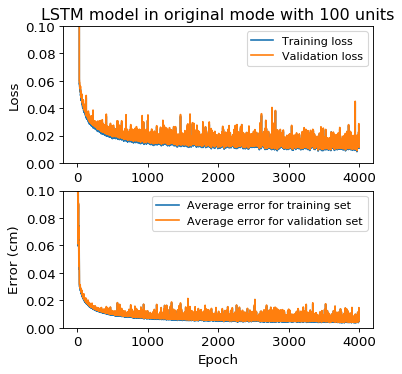

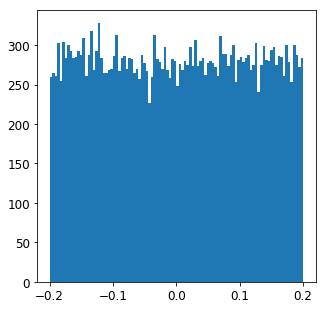

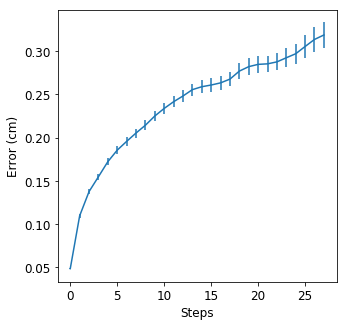

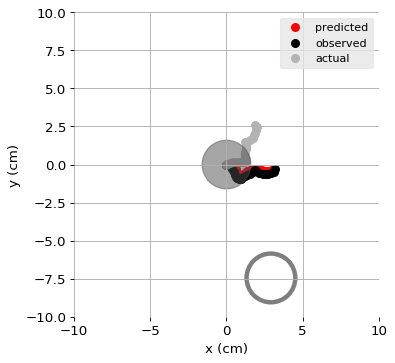

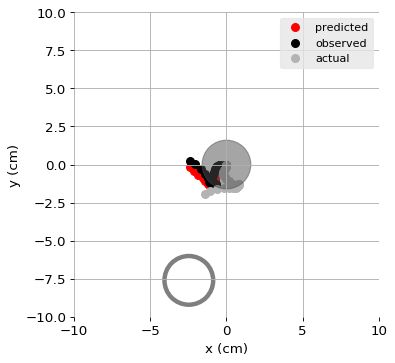

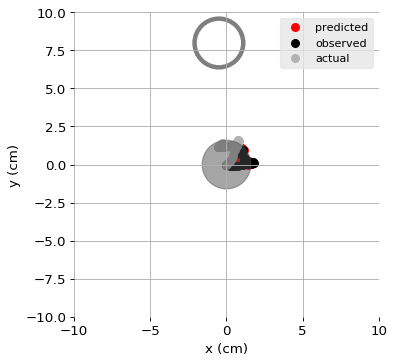

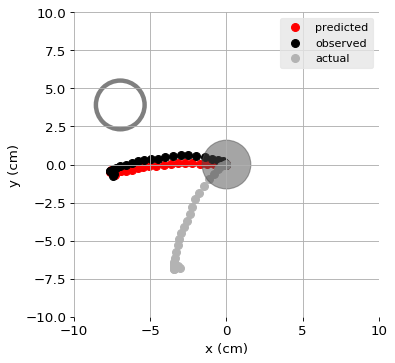

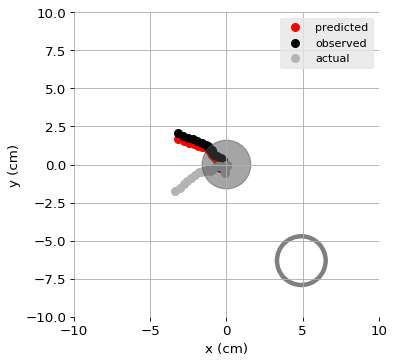

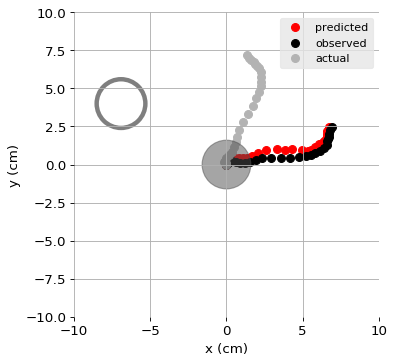

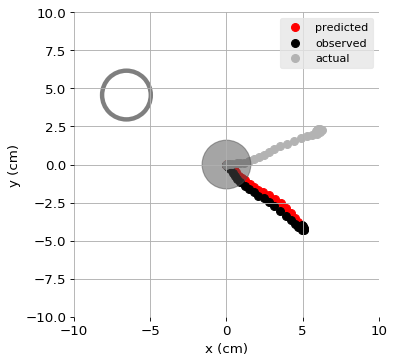

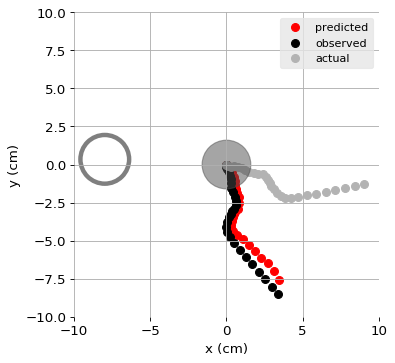

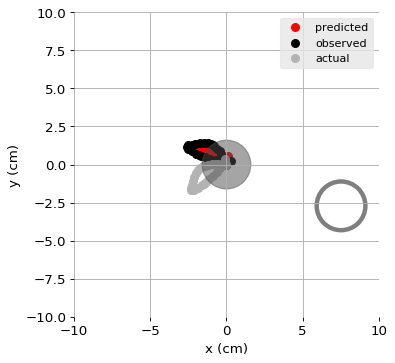

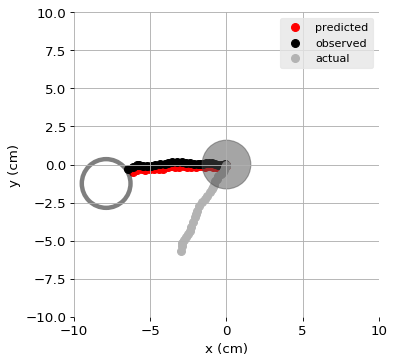

In [14]:
model_dir = 'log/14_22-23-13_original_100'
model_dir = os.path.realpath(model_dir)
utils.plot_learning_stats(model_dir=model_dir)
figs = test_model_no_planning(model_dir=model_dir, traj_num=500, max_action=0.2)

In [15]:
figs[7].savefig('figures/example_trajectory.pdf', format='pdf')
figs[7].savefig('figures/example_trajectory.eps', format='eps')